# Autocorrelation of Eye Tracking Data
This notebook calculates the autocorrelation of raw eye tracking data. 

Objectives:
* Autocorrelation plot showing time points with especially high correlation within the time series of data

## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

### Check for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Requirements

To run all of this notebook, you need the following libraries to be installed:
* ImageIO (`imageio` and `imageio-ffmpeg`): for reading images and accessing the webcam
* Scikit-image (`scikit-image`) for some image manipulation
* MatPlotLib (`matplotlib`): mainly for displaying images in the notebook
* Dlib (`dlib`) providing the HOG face detector
* OpenCV (`opencv`) for real time applications
* Imutils (`imutils`) for image manipulation with OpenCV

Running the following cell will create a file `graphs.yml` that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.


In [1]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas

Overwriting graphs.yml


## Environment Creation

To create the environment, open the. terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
```sh
conda env create -f graphs.yml
```
Remember that after running this command you have to activate the environment (Linux/MacOS: `conda activate face_norm`, Windows: `activate face_norm`) and then reopen the notebook in that environment.

In [3]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot as AC_plot 
import networkx as nX

OG_DATA_PATH = './'
# PLOTS_PATH = './Sabine_poster/map/'
DATA_PATH = './EyeBoxPos/'
PROCESSED_DATA_PATH = './Results/Autocorrelation/'

In [65]:
# Loading the first data to test the script
test_data = pd.read_csv(DATA_PATH + 'EyeBoxPos_VP1012.txt', names=['X','Y','Z']) 

# Removing the unwanted brackets from the data
test_data['X'] =  test_data['X'].apply(lambda x: x.replace('(','').replace(')','')) 
test_data['X'] = test_data['X'].astype('float')
test_data['Z'] =  test_data['Z'].apply(lambda x: x.replace('(','').replace(')','')) 
test_data['Z'] = test_data['Z'].astype('float')

test_data['time'] = test_data.index*0.03/60.0

test_data = test_data.set_index('time')

test_data[:]


,X,Y,Z
time,,,
0.0000,422.40290,-13.60316,891.8898
0.0005,422.41970,-13.56038,891.9304
0.0010,422.41440,-13.35254,891.9498
0.0015,422.41590,-13.32038,891.9532
0.0020,422.49460,-13.45451,891.9565
...,...,...,...
27.2740,121.40650,25.47238,732.8135
27.2745,119.41990,25.02592,734.2310
27.2750,0.00000,0.00000,0.0000


(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.90098663, 0.9022043 , 0.90331396, 0.9040383 , 0.90542258,
        0.90713866, 0.90913801, 0.91469012, 0.92250921, 0.94330536,
        1.        , 0.94330536, 0.92250921, 0.91469012, 0.90913801,
        0.90713866, 0.90542258, 0.9040383 , 0.90331396, 0.9022043 ,
        0.90098663]),
 <matplotlib.lines.Line2D at 0x7fc50e9b0630>)

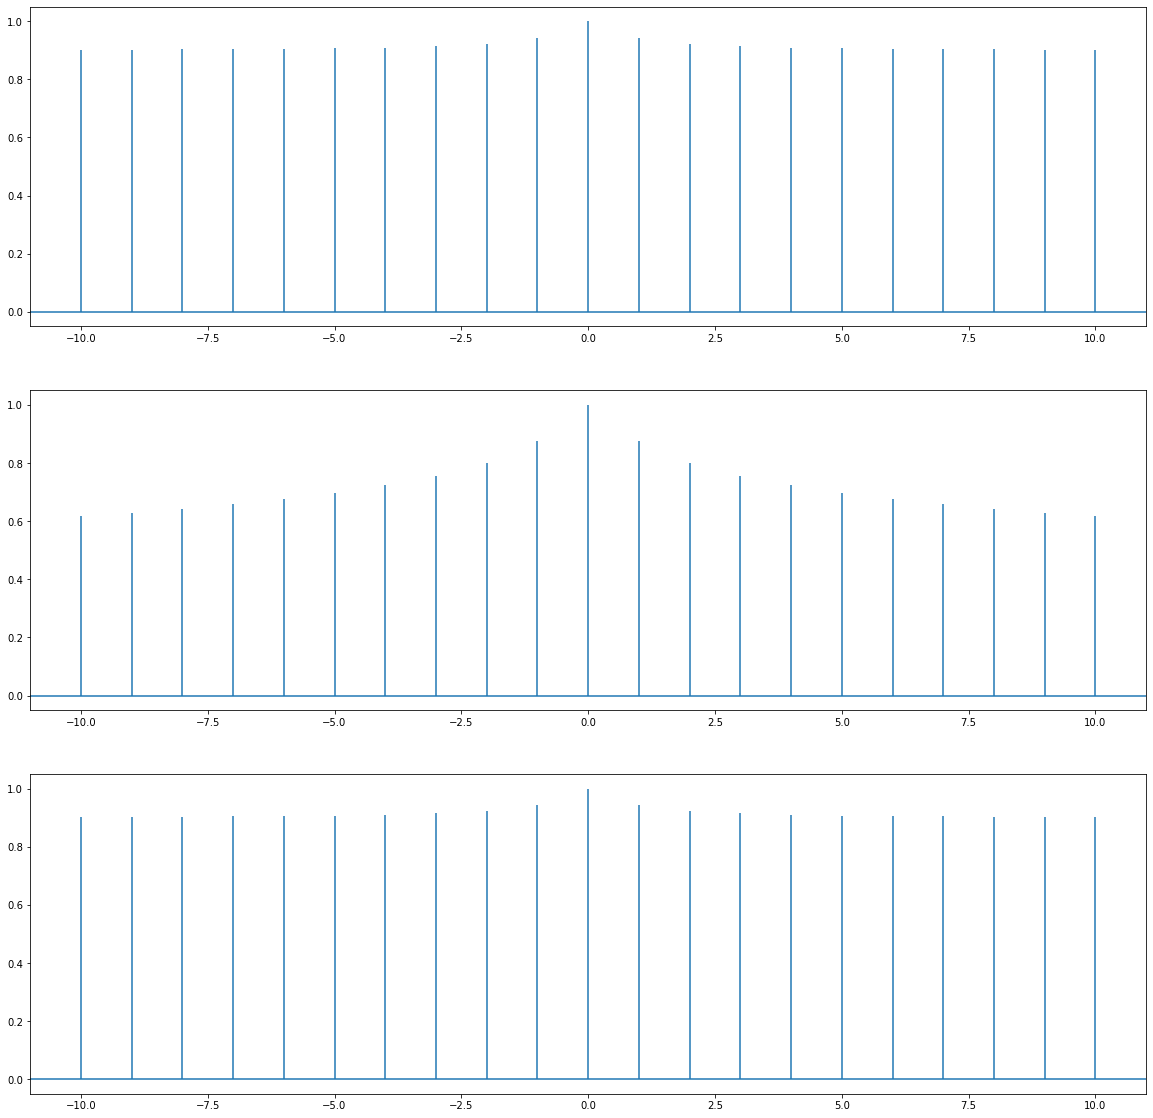

In [94]:
#plt.figure(figsize=(15,15))
#ax = AC_plot(test_data[0])
#ax = AC_plot(test_data[1])
#ax = AC_plot(test_data[2])
#ax.set_xticklabels(test_data['time'])

fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(20,20))
#plt.subplot(3,1,1)
#axes[0] = AC_plot(test_data['X'])
#plt.subplot(3,1,2)
axes[0].autocorrelation(test_data['X'])
axes[1].acorr(test_data['Y'])
axes[2].acorr(test_data['Z'])
#plot(AC_plot(test_data['Y'])  # = AC_plot(test_data['Y'])
#plt.subplot(3,1,3)
#axes[2] =  AC_plot(test_data['Z'])
#ax.set_xticklabels('time')#

In [83]:
axes

array([[<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>],
       [<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>],
       [<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>]],
      dtype=object)